In [139]:
import pandas as pd
import numpy as np
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import warnings
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
warnings.filterwarnings('ignore')

# Load Data

In [140]:
df = pd.read_csv('/kaggle/input/flowfeatures/flowFeatures.csv', usecols=lambda x: x not in ['publicIP', 'FlowID', 'SrcPort', 'DstPort','Timestamp','Protocol', 'FlowDuration'])

# Preprocessing

In [141]:
df = df[df['FlowPkts/s'] != np.inf]

In [142]:
for col, cnt in df.isna().sum().items():
  if cnt != 0:
    print(f"{col} have {cnt} null")

In [143]:
for name, cnt in np.isinf(df.select_dtypes(exclude=["object"])).sum().items():
  if cnt != 0:
    print(f"{name} have {cnt} infinity")

In [144]:
for col in df.columns:
  if len(df[col].unique()) == 1:
    df.drop(col, axis=1, inplace=True)

In [145]:
df = df.drop_duplicates()

In [146]:
df.shape

(1295864, 66)

# Data handling

In [147]:
def create_ip_pair(src_ip, dst_ip):
    return tuple(sorted([src_ip, dst_ip]))

# Tạo cặp IP đã sort cho việc nhóm
ip_pairs = [create_ip_pair(src, dst) for src, dst in zip(df['SrcIP'], df['DstIP'])]

In [148]:
lenpairs = set(ip_pairs)

In [149]:
len(lenpairs)

1884

In [150]:
# Chọn các cột số để train
numerical_columns = [col for col in df.columns
                    if col not in ['Label', 'SrcIP', 'DstIP']
                    and df[col].dtype in ['int64', 'float64']]

In [151]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset

# Chuẩn bị features 
X = df[numerical_columns] 
y = df['Label']

# Split data và thêm ip_pairs vào để nhóm sau này
X_train, X_test, y_train, y_test, pairs_train, pairs_test = train_test_split(
    X, y, ip_pairs, test_size=0.2, random_state=42, stratify=y
)

In [152]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [153]:
X_train_scaled.shape, y_train.shape

((1036691, 63), (1036691,))

In [154]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create sequences

In [155]:
class IPFlowDataset(Dataset):
    def __init__(self, X, y, ip_pairs, max_flows=100):
        self.max_flows = max_flows
        self.sequences = []
        self.labels = []
        self.lengths = []
        
        # Convert to numpy for faster processing
        X_np = X if isinstance(X, np.ndarray) else X.values
        y_np = y.values if hasattr(y, 'values') else np.array(y)
        
        # Group by IP pairs
        unique_pairs = set(ip_pairs)
        print(f"Number of unique IP pairs: {len(unique_pairs)}")
        
        for pair in unique_pairs:
            indices = [i for i, p in enumerate(ip_pairs) if p == pair]
            
            if len(indices) > 0:
                flows = X_np[indices]
                flow_labels = y_np[indices]
                
                # Tìm vị trí của các flows APT
                apt_indices = [i for i, label in enumerate(flow_labels) if label == "APT"]
                
                selected_indices = []
                if len(apt_indices) > 0.15*max_flows:  # Nếu có flows APT
                    # Đảm bảo lấy tất cả flows APT nếu có thể
                    if len(apt_indices) <= max_flows:
                        selected_indices.extend(apt_indices)
                        
                        # Số lượng flows còn có thể thêm vào
                        remaining_slots = max_flows - len(selected_indices)
                        
                        # Lấy flows xung quanh APT flows
                        surrounding_indices = set()
                        for apt_idx in apt_indices:
                            window = 10  # Số flows trước và sau mỗi APT flow
                            start = max(0, apt_idx - window)
                            end = min(len(flows), apt_idx + window + 1)
                            surrounding_indices.update(range(start, end))
                        
                        # Loại bỏ các APT indices đã có
                        surrounding_indices = surrounding_indices - set(apt_indices)
                        
                        # Thêm flows xung quanh
                        if surrounding_indices:
                            n_surrounding = min(remaining_slots, len(surrounding_indices))
                            selected_indices.extend(
                                np.random.choice(list(surrounding_indices), 
                                               size=n_surrounding, 
                                               replace=False)
                            )
                            
                        # Nếu vẫn còn slots, thêm flows ngẫu nhiên
                        remaining_slots = max_flows - len(selected_indices)
                        if remaining_slots > 0:
                            remaining_indices = list(set(range(len(flows))) - 
                                                   set(selected_indices))
                            if remaining_indices:
                                selected_indices.extend(
                                    np.random.choice(remaining_indices, 
                                                   size=remaining_slots, 
                                                   replace=False)
                                )
                    else:
                        # Nếu có quá nhiều APT flows, lấy ngẫu nhiên từ các APT flows
                        selected_indices = list(np.random.choice(apt_indices, 
                                                              size=max_flows, 
                                                              replace=False))
                else:
                    # Nếu không có flows APT, lấy ngẫu nhiên
                    if len(flows) > max_flows:
                        selected_indices = list(np.random.choice(len(flows), 
                                                              size=max_flows, 
                                                              replace=False))
                    else:
                        selected_indices = list(range(len(flows)))
                
                # Sort indices
                selected_indices = sorted(selected_indices)
                
                # Lấy selected flows
                if len(selected_indices) > max_flows:
                    selected_indices = selected_indices[:max_flows]
                
                selected_flows = flows[selected_indices]
                length = len(selected_flows)
                
                # Pad nếu cần
                if length < max_flows:
                    padding = np.zeros((max_flows - length, flows.shape[1]))
                    selected_flows = np.vstack([selected_flows, padding])
                elif length > max_flows:
                    selected_flows = selected_flows[:max_flows]
                    length = max_flows
                
                self.sequences.append(selected_flows)
                self.labels.append(1 if len(apt_indices) >= 0.1*max_flows else 0)
                self.lengths.append(length)
        
        print(f"Total sequences: {len(self.sequences)}")
        print(f"APT sequences: {sum(self.labels)}")
        
        # Convert to tensors
        self.sequences = torch.FloatTensor(np.array(self.sequences))
        self.labels = torch.FloatTensor(self.labels)
        self.lengths = torch.LongTensor(self.lengths)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return (
            self.sequences[idx],
            self.labels[idx],
            self.lengths[idx]
        )

# Prepare data loaders for training

In [156]:
batch_size = 32

train_dataset = IPFlowDataset(X_train_scaled, y_train, pairs_train)
test_dataset = IPFlowDataset(X_test_scaled, y_test, pairs_test)

Number of unique IP pairs: 1804
Total sequences: 1804
APT sequences: 217
Number of unique IP pairs: 1270
Total sequences: 1270
APT sequences: 211


In [157]:
from diffusers import UNet1DModel

In [158]:
from diffusers import DDPMScheduler

In [159]:
# Define Diffusion model with larger fixed size
model = UNet1DModel(
    sample_size=64,  # Increased sequence length
    in_channels=train_dataset.sequences.shape[2],  # number of features
    out_channels=train_dataset.sequences.shape[2],  # number of features
    layers_per_block=1,  # Single layer per block
    block_out_channels=(32, 64),  # Reduced number of blocks
    mid_block_type="UNetMidBlock1D",
    down_block_types=["DownBlock1D", "DownBlock1D"],  # Reduced number of blocks
    up_block_types=["UpBlock1D", "UpBlock1D"]  # Reduced number of blocks
).to(device)

noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000,
    beta_schedule="linear",
    prediction_type="epsilon",
    clip_sample=True,
    clip_sample_range=1.0
)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

def train_diffusion(model, dataset, noise_scheduler, optimizer, num_epochs=50, batch_size=32):
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    model.train()

    for epoch in range(num_epochs):
        total_loss = 0
        for step, batch in enumerate(dataloader):
            clean = batch[0].to(device)
            # Take first 64 timesteps
            clean = clean[:, :64, :]
            # Transpose the input to match UNet1D's expected format (batch, channels, seq_len)
            clean = clean.transpose(1, 2)
            
            noise = torch.randn_like(clean).to(device)
            timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (clean.shape[0],), device=device).long()
            noisy = noise_scheduler.add_noise(clean, noise, timesteps)

            noise_pred = model(noisy, timesteps).sample
            loss = nn.MSELoss()(noise_pred, noise)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")

In [160]:
# Calculate n_synthetic before using it
n_synthetic = int(len(train_dataset.sequences) - 2 * sum(train_dataset.labels).item())
print(f"Generating {n_synthetic} synthetic sequences")

# Sampling synthetic sequences from trained diffusion model
model.eval()
with torch.no_grad():
    # Create noise with correct dimensions (batch, channels, seq_len)
    noisy = torch.randn(n_synthetic, train_dataset.sequences.shape[2], 64).to(device)
    for t in reversed(range(noise_scheduler.num_train_timesteps)):
        noisy = noise_scheduler.step(model(noisy, torch.tensor([t]*n_synthetic).to(device)).sample, t, noisy).prev_sample

    # Transpose back to original format (batch, seq_len, features)
    synthetic_sequences = noisy.transpose(1, 2)  # shape: (n_synthetic, 64, feature_dim)
    
    # Pad to original sequence length
    padded_sequences = torch.zeros(n_synthetic, train_dataset.sequences.shape[1], train_dataset.sequences.shape[2])
    padded_sequences[:, :64, :] = synthetic_sequences
    synthetic_sequences = padded_sequences

Generating 1370 synthetic sequences


In [161]:

# Gọi huấn luyện mô hình Diffusion
train_diffusion(model, train_dataset, noise_scheduler, optimizer, num_epochs=50, batch_size=32)


Epoch 1/50, Average Loss: 1.2305
Epoch 2/50, Average Loss: 1.0381
Epoch 3/50, Average Loss: 1.0114
Epoch 4/50, Average Loss: 1.0034
Epoch 5/50, Average Loss: 0.9940
Epoch 6/50, Average Loss: 0.9889
Epoch 7/50, Average Loss: 0.9830
Epoch 8/50, Average Loss: 0.9780
Epoch 9/50, Average Loss: 0.9714
Epoch 10/50, Average Loss: 0.9651
Epoch 11/50, Average Loss: 0.9609
Epoch 12/50, Average Loss: 0.9547
Epoch 13/50, Average Loss: 0.9520
Epoch 14/50, Average Loss: 0.9451
Epoch 15/50, Average Loss: 0.9402
Epoch 16/50, Average Loss: 0.9337
Epoch 17/50, Average Loss: 0.9285
Epoch 18/50, Average Loss: 0.9262
Epoch 19/50, Average Loss: 0.9203
Epoch 20/50, Average Loss: 0.9154
Epoch 21/50, Average Loss: 0.9095
Epoch 22/50, Average Loss: 0.9034
Epoch 23/50, Average Loss: 0.8996
Epoch 24/50, Average Loss: 0.8954
Epoch 25/50, Average Loss: 0.8918
Epoch 26/50, Average Loss: 0.8868
Epoch 27/50, Average Loss: 0.8843
Epoch 28/50, Average Loss: 0.8803
Epoch 29/50, Average Loss: 0.8750
Epoch 30/50, Average Lo

In [162]:
# Add synthetic sequences to training data
train_dataset.sequences = torch.cat([train_dataset.sequences, synthetic_sequences], dim=0)
train_dataset.labels = torch.cat([train_dataset.labels, torch.ones(n_synthetic)], dim=0)
train_dataset.lengths = torch.cat([train_dataset.lengths, torch.full((n_synthetic,), 64, dtype=torch.long)], dim=0)

print(f"Training dataset size after adding synthetic data: {len(train_dataset.sequences)}")
print(f"Number of APT sequences: {sum(train_dataset.labels).item()}")
print(f"Number of normal sequences: {len(train_dataset.labels) - sum(train_dataset.labels).item()}")

Training dataset size after adding synthetic data: 3174
Number of APT sequences: 1587.0
Number of normal sequences: 1587.0


In [163]:
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    pin_memory=True
)

In [164]:
import torch
import torch.nn as nn

class FlowTransformer(nn.Module):
    def __init__(self, input_size, hidden_size=128, nhead=8, num_layers=2):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.LayerNorm(hidden_size),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_size,
            nhead=nhead,
            dim_feedforward=hidden_size*4,
            dropout=0.3,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.LayerNorm(hidden_size),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, x, lengths):
        batch_size, seq_len, _ = x.size()
        x = self.feature_extractor(x)

        # Padding mask: True = vị trí cần bỏ qua
        src_key_padding_mask = torch.arange(seq_len).unsqueeze(0).expand(batch_size, -1).to(x.device) >= lengths.unsqueeze(1)

        # Transformer encoder
        transformer_out = self.transformer(x, src_key_padding_mask=src_key_padding_mask)

        # Average pooling (bỏ qua padding)
        mask = (~src_key_padding_mask).float().unsqueeze(-1)
        pooled = (transformer_out * mask).sum(dim=1) / mask.sum(dim=1)

        return self.classifier(pooled)

In [165]:
@torch.cuda.amp.autocast()
def train_epoch(model, train_loader, criterion, optimizer, scaler):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    for batch_flows, batch_labels, batch_lengths in train_loader:
        batch_flows = batch_flows.to(device)
        batch_labels = batch_labels.to(device)
        batch_lengths = batch_lengths.to(device)

        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            outputs = model(batch_flows, batch_lengths)
            outputs = outputs.view(-1)
            loss = criterion(outputs, batch_labels)

        scaler.scale(loss).backward()
        # Gradient clipping
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()

        preds = torch.sigmoid(outputs.detach())
        preds = (preds > 0.5).float()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_labels.cpu().numpy())

    return {
        'loss': total_loss / len(train_loader),
        'accuracy': accuracy_score(all_labels, all_preds),
        'precision': precision_score(all_labels, all_preds),
        'recall': recall_score(all_labels, all_preds),
        'f1': f1_score(all_labels, all_preds)
    }

@torch.no_grad()
def evaluate(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    total_loss = 0
    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([3.0]).to(device))

    for batch_flows, batch_labels, batch_lengths in test_loader:
        batch_flows = batch_flows.to(device)
        batch_labels = batch_labels.to(device)
        batch_lengths = batch_lengths.to(device)

        outputs = model(batch_flows, batch_lengths)
        outputs = outputs.view(-1)
        loss = criterion(outputs, batch_labels)
        total_loss += loss.item()

        preds = torch.sigmoid(outputs)
        preds = (preds > 0.5).float()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_labels.cpu().numpy())

    return {
        'loss': total_loss / len(test_loader),
        'accuracy': accuracy_score(all_labels, all_preds),
        'precision': precision_score(all_labels, all_preds),
        'recall': recall_score(all_labels, all_preds),
        'f1': f1_score(all_labels, all_preds)
    }

def train_model(model, train_loader, test_loader, epochs=15):
    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([3.0]).to(device))
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=0.0001,
        weight_decay=0.01,
        betas=(0.9, 0.999),
        eps=1e-8
    )
    
    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=3, verbose=True
    )

    scaler = torch.cuda.amp.GradScaler()
    best_f1 = 0
    patience = 10
    no_improve = 0
    best_epoch = 0

    for epoch in range(epochs):
        # Train
        train_metrics = train_epoch(model, train_loader, criterion, optimizer, scaler)

        # Evaluate
        test_metrics = evaluate(model, test_loader)
        
        # Update learning rate
        scheduler.step(test_metrics['f1'])

        # Early stopping
        if test_metrics['f1'] > best_f1:
            best_f1 = test_metrics['f1']
            best_state = model.state_dict()
            best_epoch = epoch
            no_improve = 0
        else:
            no_improve += 1

        if no_improve >= patience:
            print(f"\nEarly stopping at epoch {epoch+1}")
            print(f"Best F1 score was at epoch {best_epoch+1}")
            model.load_state_dict(best_state)
            break

        # Print metrics
        print(f'\nEpoch {epoch+1}/{epochs}')
        print(f'Train - Loss: {train_metrics["loss"]:.4f}, Acc: {train_metrics["accuracy"]:.4f}, '
              f'Prec: {train_metrics["precision"]:.4f}, Rec: {train_metrics["recall"]:.4f}, '
              f'F1: {train_metrics["f1"]:.4f}')
        print(f'Test  - Loss: {test_metrics["loss"]:.4f}, Acc: {test_metrics["accuracy"]:.4f}, '
              f'Prec: {test_metrics["precision"]:.4f}, Rec: {test_metrics["recall"]:.4f}, '
              f'F1: {test_metrics["f1"]:.4f}')

    # Final evaluation
    model.eval()
    final_metrics = evaluate(model, test_loader)
    print("\nFinal Test Results:")
    print(f"Accuracy: {final_metrics['accuracy']:.4f}")
    print(f"Precision: {final_metrics['precision']:.4f}")
    print(f"Recall: {final_metrics['recall']:.4f}")
    print(f"F1 Score: {final_metrics['f1']:.4f}")

    return model, final_metrics

# Training and evaluate

In [166]:
# Initialize model with appropriate hyperparameters
input_size = X_train_scaled.shape[1]  # Số features gốc
hidden_size = 256  # Tăng hidden size để model có thể học tốt hơn
model = FlowTransformer(
    input_size=input_size,
    hidden_size=hidden_size
).to(device)

# Print model summary
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Define training parameters
training_config = {
    'epochs': 20,  # Tăng số epochs
    'batch_size': 64,  # Điều chỉnh batch size
    'learning_rate': 0.0001,
    'weight_decay': 0.01,
    'pos_weight': 3.0,  # Weight cho positive class
    'patience': 10,  # Early stopping patience
    'gradient_clip': 1.0  # Gradient clipping threshold
}

# Create data loaders with new batch size
train_loader = DataLoader(
    train_dataset, 
    batch_size=training_config['batch_size'],
    shuffle=True,
    num_workers=4,  # Thêm num_workers để tăng tốc độ loading
    pin_memory=True  # Sử dụng pin_memory để tăng tốc độ transfer data to GPU
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=training_config['batch_size'],
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

# Train model với các hàm train_epoch và evaluate đã có
trained_model, final_metrics = train_model(
    model, 
    train_loader, 
    test_loader,
    epochs=training_config['epochs']
)

# Save the best model
torch.save({
    'model_state_dict': trained_model.state_dict(),
    'input_size': input_size,
    'hidden_size': hidden_size,
    'final_metrics': final_metrics
}, 'best_flow_transformer.pth')

# Print final results
print("\nTraining completed!")
print(f"Final Test Metrics:")
print(f"Accuracy: {final_metrics['accuracy']:.4f}")
print(f"Precision: {final_metrics['precision']:.4f}")
print(f"Recall: {final_metrics['recall']:.4f}")
print(f"F1 Score: {final_metrics['f1']:.4f}")

Total parameters: 1,662,977
Trainable parameters: 1,662,977

Epoch 1/20
Train - Loss: 1.7598, Acc: 0.2984, Prec: 0.1507, Rec: 0.0870, F1: 0.1103
Test  - Loss: 1.8689, Acc: 0.1661, Prec: 0.1661, Rec: 1.0000, F1: 0.2849

Epoch 2/20
Train - Loss: 1.2009, Acc: 0.5000, Prec: 0.5000, Rec: 1.0000, F1: 0.6667
Test  - Loss: 1.9882, Acc: 0.8339, Prec: 0.0000, Rec: 0.0000, F1: 0.0000

Epoch 3/20
Train - Loss: 5.8878, Acc: 0.5000, Prec: 0.0000, Rec: 0.0000, F1: 0.0000
Test  - Loss: 0.8977, Acc: 0.8339, Prec: 0.0000, Rec: 0.0000, F1: 0.0000

Epoch 4/20
Train - Loss: 2.0080, Acc: 0.5000, Prec: 0.0000, Rec: 0.0000, F1: 0.0000
Test  - Loss: 2.0624, Acc: 0.1661, Prec: 0.1661, Rec: 1.0000, F1: 0.2849

Epoch 5/20
Train - Loss: 1.3424, Acc: 0.5000, Prec: 0.5000, Rec: 1.0000, F1: 0.6667
Test  - Loss: 0.8843, Acc: 0.8339, Prec: 0.0000, Rec: 0.0000, F1: 0.0000

Epoch 6/20
Train - Loss: 1.8040, Acc: 0.4984, Prec: 0.4468, Rec: 0.0132, F1: 0.0257
Test  - Loss: 1.1031, Acc: 0.1661, Prec: 0.1661, Rec: 1.0000, F1:

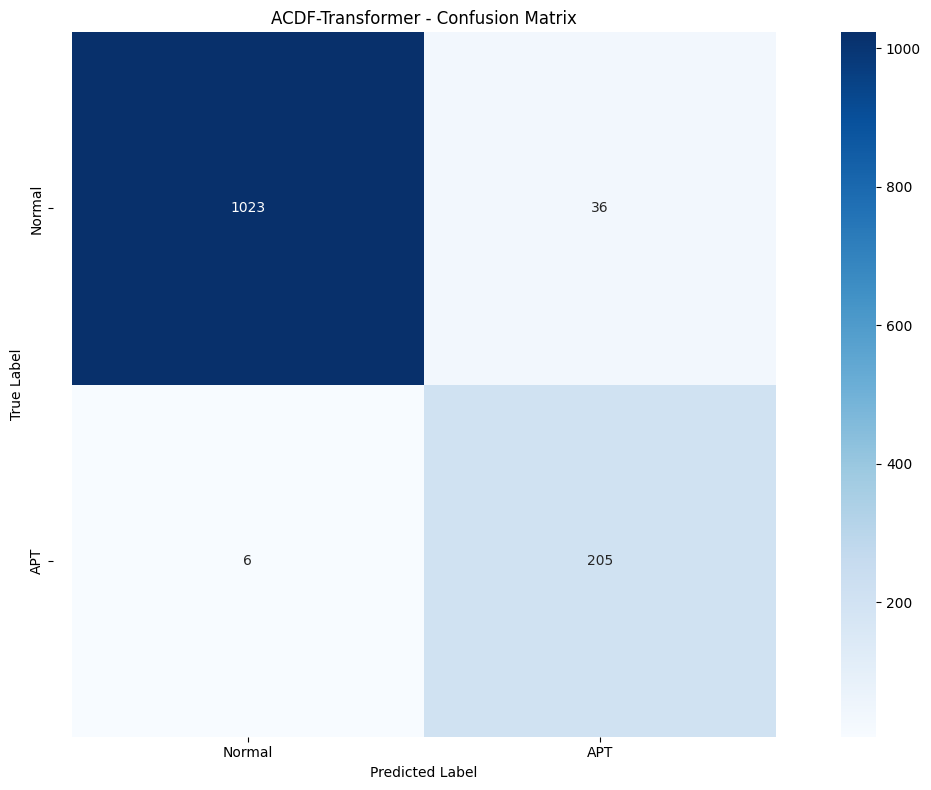


Detailed Classification Report:
Total samples: 1270
Accuracy: 0.9669
Precision: 0.8506
Recall: 0.9716
F1 Score: 0.9071

Confusion Matrix:
True Negatives: 1023
False Positives: 36
False Negatives: 6
True Positives: 205


In [167]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

def plot_confusion_matrix(model, test_loader, title='Confusion Matrix'):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []  # Lưu probabilities để tính ROC curve sau này nếu cần

    with torch.no_grad():
        for batch_flows, batch_labels, batch_lengths in test_loader:
            batch_flows = batch_flows.to(device)
            batch_lengths = batch_lengths.to(device)

            outputs = model(batch_flows, batch_lengths)
            outputs = outputs.view(-1)

            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_labels.numpy())
            all_probs.extend(probs.cpu().numpy())
    
    # Tính toán confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=[0, 1])

    # Tính toán các metrics
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Tạo figure với kích thước lớn hơn
    plt.figure(figsize=(10, 8))

    # Vẽ confusion matrix với seaborn
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'APT'],
                yticklabels=['Normal', 'APT'])

    # Thêm labels và title
    plt.title("ACDF-Transformer - Confusion Matrix")
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.axis('equal')
    
    # Thêm số liệu chi tiết
    
    # Điều chỉnh layout
    plt.tight_layout()
    
    # Lưu figure
    plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

    # In thêm thông tin chi tiết
    print("\nDetailed Classification Report:")
    print(f"Total samples: {len(all_labels)}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"\nConfusion Matrix:")
    print(f"True Negatives: {tn}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"True Positives: {tp}")

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm,
        'predictions': all_preds,
        'probabilities': all_probs,
        'true_labels': all_labels
    }

# Gọi hàm để hiển thị confusion matrix
metrics = plot_confusion_matrix(model, test_loader, title='ACDF-Transformer - Confusion Matrix')

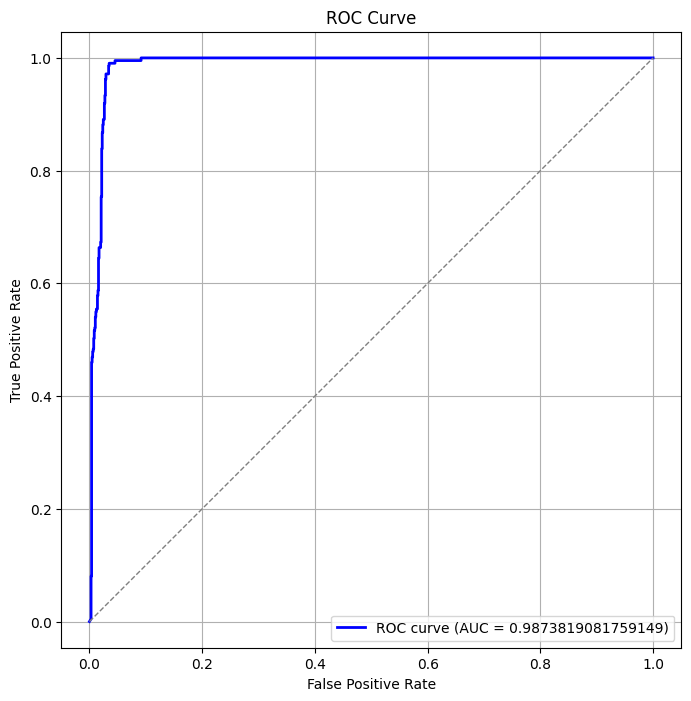

AUC: 0.9873819081759149


In [168]:
# Vẽ ROC Curve và tính AUC dựa trên metrics đã có
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Lấy nhãn thực tế và xác suất dự đoán từ metrics
y_true = metrics['true_labels']
y_probs = metrics['probabilities']

# Tính toán FPR, TPR và AUC
fpr, tpr, _ = roc_curve(y_true, y_probs)
roc_auc = roc_auc_score(y_true, y_probs)

# Vẽ ROC Curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')  # Đường chéo random
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.axis('equal')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# In giá trị AUC
print("AUC:", roc_auc)

In [169]:
  original_sequences = train_dataset.sequences.clone()

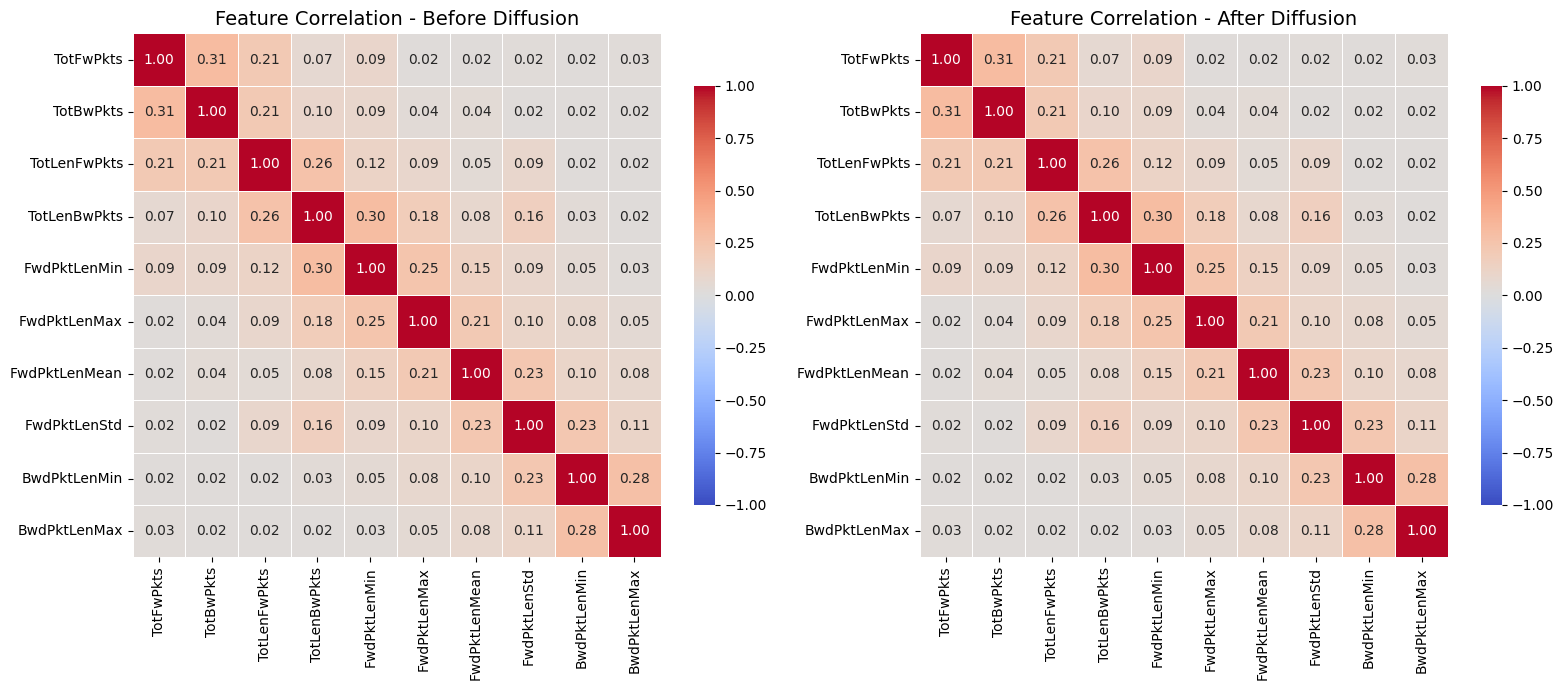

In [170]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Giả sử bạn đã có train_dataset.sequences là tensor (N, seq_len, num_features)
# Và đã thêm synthetic sequences vào train_dataset.sequences

# 1. Đặt tên các feature đúng thứ tự với dữ liệu của bạn
feature_names = [
    'TotFwPkts', 'TotBwPkts', 'TotLenFwPkts', 'TotLenBwPkts',
    'FwdPktLenMin', 'FwdPktLenMax', 'FwdPktLenMean', 'FwdPktLenStd',
    'BwdPktLenMin', 'BwdPktLenMax'
    # Nếu bạn có nhiều feature hơn, hãy bổ sung vào đây cho đủ
]

selected_features = feature_names  # hoặc chọn subset nếu muốn

# Trước khi thêm synthetic
data_before = original_sequences.cpu().numpy().reshape(-1, len(feature_names))
df_before = pd.DataFrame(data_before, columns=feature_names)

# Sau khi thêm synthetic
data_after = train_dataset.sequences.cpu().numpy().reshape(-1, len(feature_names))
df_after = pd.DataFrame(data_after, columns=feature_names)

# 2. Dữ liệu trước khi Diffusion (giả sử bạn đã lưu lại trước khi thêm synthetic)
# Ví dụ: data_before = original_sequences (tensor trước khi thêm synthetic)
# Nếu chưa lưu, bạn cần lấy lại từ dữ liệu gốc trước khi thêm synthetic
# data_before = original_sequences.cpu().numpy().reshape(-1, len(feature_names))
# df_before = pd.DataFrame(data_before, columns=feature_names)

# 3. Dữ liệu sau khi Diffusion (train_dataset.sequences đã được cập nhật)
# data_after = train_dataset.sequences.cpu().numpy().reshape(-1, len(feature_names))
# df_after = pd.DataFrame(data_after, columns=feature_names)

# 4. Tính correlation
corr_before = df_before[selected_features].corr()
corr_after = df_after[selected_features].corr()

# 5. Vẽ 2 heatmap cạnh nhau
plt.figure(figsize=(16, 7))

plt.subplot(1, 2, 1)
sns.heatmap(
    corr_before, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1,
    linewidths=0.5, cbar_kws={"shrink": 0.8}
)
plt.title("Feature Correlation - Before Diffusion", fontsize=14)

plt.subplot(1, 2, 2)
sns.heatmap(
    corr_after, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1,
    linewidths=0.5, cbar_kws={"shrink": 0.8}
)
plt.title("Feature Correlation - After Diffusion", fontsize=14)

plt.tight_layout()
plt.show()

In [171]:
checkpoint = torch.load('best_flow_transformer.pth', map_location='cpu', weights_only=False)
print("Final metrics:")
for k, v in checkpoint['final_metrics'].items():
    print(f"  {k:<15}: {v:.4f}")

Final metrics:
  loss           : 0.1487
  accuracy       : 0.9669
  precision      : 0.8506
  recall         : 0.9716
  f1             : 0.9071
